In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
from prepare_data import *
from data import *

In [2]:
training_address="food-101/train.csv"
test_address="food-101/test.csv"

In [3]:
train,val,test=get_dataloaders(training_address, test_address, args=None)

In [4]:
import torch.optim as optim
import torch.nn.functional as F
def prepare_model(device, model):
    # load model, criterion, optimizer, and learning rate scheduler
    
    # Create an empty model and move it to the designated computing device
    model=model.to(device)


    return model

def train_single_model(model, criterion, optimizer, scheduler, device, dataloaders,epoch):
    
    # prepare the model
    model=prepare_model(device,model)
    
    # store the results of our training
    training_losses=[]
    training_accs=[]
    val_losses=[]
    val_accs=[]

    for i in range(epoch):
        # train the model in each epoch
        model.train()
        for batch_idx, (data, target) in enumerate(dataloaders[0]):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad() # clear the old gradients 
            output = model(data) # compute outputs of the fc layer 
            loss = criterion(output, target) 
            loss.backward() # compute gradient for every variables with requires_grad=True
            optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        print("finish a epoch of training")
            
        # test the model with the training data:
        model.eval() # sets model in evaluation (inference) mode. Q3. Why? 
        training_loss = 0 
        correct = 0
        with torch.no_grad(): # stop storing gradients for the variables
            for data, target in dataloaders[0]:
                data, target = data.to(device), target.to(device)
                output = model(data)
                training_loss+=criterion(output, target)
                pred = output.argmax(dim=1, keepdim=True) # get the index of maximum fc output. Q4. Why?
                correct += pred.eq(target.view_as(pred)).sum().item()
        training_loss /= len(dataloaders[0].dataset)
        training_losses.append(training_loss)
        training_acc=correct / len(dataloaders[0].dataset)
        training_accs.append(training_acc)
        
        
        # test the model with validation data in each epoch
        model.eval() # sets model in evaluation (inference) mode. Q3. Why? 
        val_loss = 0 
        correct = 0
        with torch.no_grad(): # stop storing gradients for the variables
            for data, target in dataloaders[1]:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss+=criterion(output, target)
                pred = output.argmax(dim=1, keepdim=True) # get the index of maximum fc output. Q4. Why?
                correct += pred.eq(target.view_as(pred)).sum().item()
        val_loss /= len(dataloaders[1].dataset)
        val_losses.append(val_loss)
        val_acc=correct / len(dataloaders[1].dataset)
        val_accs.append(val_acc)
        print("epoch_num: "+str(i))
        print("train_loss: "+str(training_loss))
        print("val_loss: "+str(val_loss))

    torch.save(model.state_dict(), "food-101/state_dict_model.pt")
    return model,training_losses,training_accs,val_losses,val_accs

In [5]:
a=[train,val,test]

In [6]:
class vgg(nn.Module):
    def __init__(self):
        super(vgg, self).__init__()
        temp=models.vgg16_bn(pretrained=True)
        
        for param in temp.parameters():
            param.requires_grad = False

        # change the last layer
        temp.classifier[6] = nn.Linear(in_features=4096, out_features=20, bias=True)
        
        # unfreeze the final layer this time for extra tuning
        temp.classifier[6].weight.requires_grad = True
        temp.classifier[6].bias.requires_grad = True
        
        model_ft = temp.to("cuda:0")
        self.model=model_ft
        
    def forward(self, x):
        x=self.model(x)
        return x

In [7]:
model=vgg()
criterion=nn.CrossEntropyLoss()
# optimizer=optim.Adam(model.parameters(), lr=2e-4)
optimizer = optim.Adam(model.parameters(), lr=5e-4)
nn.init.xavier_uniform_(model.classifier[6].weight)
nn.init.zeros_(model.classifier[6].bias)

In [8]:
m1,tl1,tc1,vl1,vc1=train_single_model(model, criterion, optimizer, scheduler=None, device="cuda:0", dataloaders=a,epoch=10)

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


finish a epoch of training
epoch_num: 0
train_loss: tensor(0.0703, device='cuda:0')
val_loss: tensor(0.0754, device='cuda:0')
finish a epoch of training
epoch_num: 1
train_loss: tensor(0.0632, device='cuda:0')
val_loss: tensor(0.0720, device='cuda:0')
finish a epoch of training
epoch_num: 2
train_loss: tensor(0.0604, device='cuda:0')
val_loss: tensor(0.0709, device='cuda:0')
finish a epoch of training
epoch_num: 3
train_loss: tensor(0.0568, device='cuda:0')
val_loss: tensor(0.0696, device='cuda:0')
finish a epoch of training
epoch_num: 4
train_loss: tensor(0.0532, device='cuda:0')
val_loss: tensor(0.0671, device='cuda:0')
finish a epoch of training
epoch_num: 5
train_loss: tensor(0.0519, device='cuda:0')
val_loss: tensor(0.0681, device='cuda:0')
finish a epoch of training
epoch_num: 6
train_loss: tensor(0.0504, device='cuda:0')
val_loss: tensor(0.0680, device='cuda:0')
finish a epoch of training
epoch_num: 7
train_loss: tensor(0.0496, device='cuda:0')
val_loss: tensor(0.0689, device='c

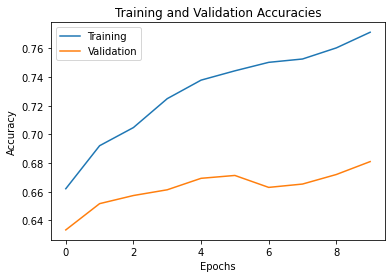

In [11]:
plt.plot(tc1, label='Training')
plt.plot(vc1, label='Validation')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
import math
import matplotlib.pyplot as plt

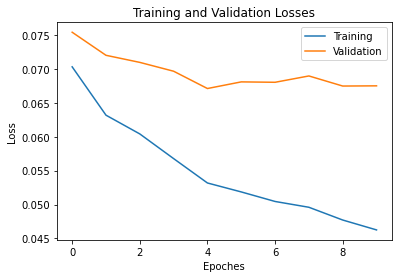

In [12]:
plt.plot(tl1, label='Training')
plt.plot(vl1, label='Validation')
plt.title('Training and Validation Losses')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
model.eval() # sets model in evaluation (inference) mode.
correct = 0
with torch.no_grad(): # stop storing gradients for the variables
    for data, target in a[2]:
            data, target = data.to("cuda:0"), target.to("cuda:0")
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True) # get the index of maximum fc output. 
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_acc=correct / len(a[2].dataset)
print("test accu: ",test_acc)

test accu:  0.6862


In [14]:
#save weights
torch.save(m1.state_dict(),"food-101/state_dict_model_vgg_freeze.pt")

In [16]:
#load model
model = vgg() # we do not specify pretrained=True, i.e. do not load default weights
model.load_state_dict(torch.load('food-101/state_dict_model_vgg_freeze.pt'))
model.eval()

vgg(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [ ]:
model.eval() # sets model in evaluation (inference) mode.
correct = 0
with torch.no_grad(): # stop storing gradients for the variables
    for data, target in a[2]:
            data, target = data.to("cuda:0"), target.to("cuda:0")
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True) # get the index of maximum fc output. 
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_acc=correct / len(a[2].dataset)
print("test accu: ",test_acc)